# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.457287,True,8.646741
1,0.747700,True,8.452898
2,0.875473,False,1.950375
3,0.166488,False,1.003343
4,2.208260,True,9.351602
...,...,...,...
995,1.820145,True,10.513021
996,1.234316,True,7.121028
997,0.992891,True,6.199318
998,1.284357,False,3.027734


<AxesSubplot: xlabel='v0'>

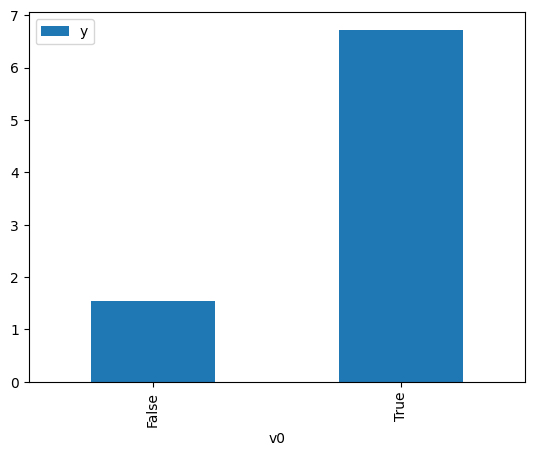

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

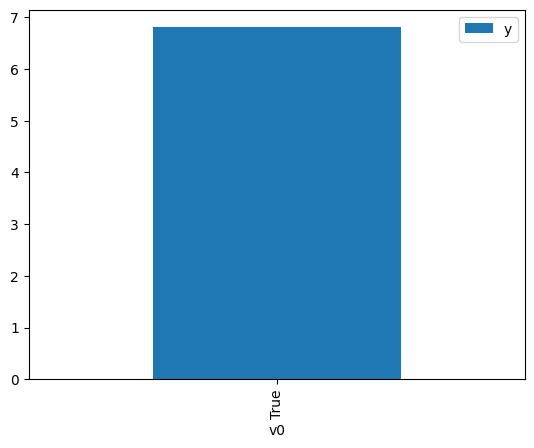

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.407103,False,3.490308,0.083508,11.974843
1,-0.082321,False,0.292104,0.522553,1.913681
2,0.755723,False,1.231772,0.212748,4.700393
3,-0.337036,False,-2.439381,0.626071,1.597263
4,2.432504,False,5.885953,0.016190,61.765474
...,...,...,...,...,...
995,0.733849,False,0.577474,0.218927,4.567736
996,1.135329,False,1.945608,0.125427,7.972743
997,-0.337595,False,-0.769321,0.626290,1.596705
998,0.690738,False,3.520266,0.231479,4.320043


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.308391,True,2.580572,0.385187,2.596143
1,0.391715,True,6.225666,0.668388,1.496137
2,0.717280,True,6.949139,0.776308,1.288149
3,0.215376,True,4.293439,0.600270,1.665918
4,-0.608431,True,3.930855,0.275207,3.633629
...,...,...,...,...,...
995,0.692377,True,6.179087,0.769007,1.300378
996,1.240776,True,8.982915,0.892641,1.120272
997,1.548809,True,10.468078,0.932900,1.071926
998,1.203342,True,7.826497,0.886505,1.128026


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                          2.254e+04
Date:                Tue, 25 Oct 2022   Prob (F-statistic):                        0.00
Time:                        18:54:35   Log-Likelihood:                         -1416.3
No. Observations:                1000   AIC:                                      2837.
Df Residuals:                     998   BIC:                                      2846.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5430      0.038     67.078      0.000       2.469       2.617
x2             4.9570      0.055     90.721      0.000       4.850       5.064
==============================================================================
Omnibus:                        0.831   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.914
Skew:                          -0.055   Prob(JB):                        0.633
Kurtosis:                       2.901   Cond. No.                         2.72
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""